In [2]:
#https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

## Functions to remove outlier
IQR based filter and Standard deviation based filter

In [47]:
#https://www.linkedin.com/pulse/how-handle-outliers-piyush-kumar/
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers on one column, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
from scipy import stats
#remove outlier based on IQR
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out   



#remove outlier based on standard deviation
def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh) \
        .all(axis=1)
    
    return df.drop(df.index[~constrains], inplace=False)


## One function that can remove or cap outliers

In [69]:
def treatoutliers(df, columns=None, factor=2, method='IQR', treament='cap'):
     
#     if not columns:
#         columns = self.mandatory_cols_ + self.optional_cols_ + [self.target_col]
    if not columns:
        columns = df.select_dtypes(include=[np.number]).columns #find all numeric columns
    
    for column in columns:
        if method == 'STD':
            permissable_std = factor * df[column].std()
            col_mean = df[column].mean()
            floor, ceil = col_mean - permissable_std, col_mean + permissable_std
            print("column:"+column+ " floor:"+str(floor)+" ceil:"+str(ceil))
            
        elif method == 'IQR':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
        
        if treament == 'remove':
            df = df[(df[column] >= floor) & (df[column] <= ceil)]
        elif treament == 'cap':
            df[column] = df[column].clip(floor, ceil)
            
    return df

## Functions to cap outliers in a data series

In [50]:
#importing pandas and numpy libraries
import pandas as pd
import numpy as np

#initializing pandas series
series = pd.Series(np.logspace(-2, 2, 100))  #generate 10^-2, ...10^2, 100 numbers 

#set the lower and higher percentile range
lower_percentile = 0.05
higher_percentile = 0.95

#returns values at the given quantile within the specified range
low, high = series.quantile([lower_percentile, higher_percentile])

#cap values below low to low
series[series < low] = low

#cap values above high to high
series[series > high] = high

print(series)    

print(lower_percentile, 'low percentile: ', low)
print(higher_percentile, 'high percentile: ', high)

0      0.015852
1      0.015852
2      0.015852
3      0.015852
4      0.015852
        ...    
95    63.109075
96    63.109075
97    63.109075
98    63.109075
99    63.109075
Length: 100, dtype: float64
0.05 low percentile:  0.015852100925988346
0.95 high percentile:  63.109074749600296


In [88]:
df = pd.read_excel("Superstore.xls")

In [6]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [89]:
df.Sales.describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

In [90]:
df_filtered=df.copy()
treatoutliers(df_filtered,  factor=3, method='STD', treament='cap')
df_filtered.Sales.describe()

column:Row ID floor:-3657.990887292297 ceil:13652.990887292297
column:Postal Code floor:-41000.70062343758 ceil:151381.45947875077
column:Sales floor:-1639.8773006955516 ceil:2099.5933023565394
column:Quantity floor:-2.8857553291777345 ceil:10.46490281767083
column:Discount floor:-0.4631531818441059 ceil:0.7755586251100846
column:Profit floor:-674.123426765088 ceil:731.4372193806576


count    9994.000000
mean      204.944608
std       370.864248
min         0.444000
25%        17.280000
50%        54.490000
75%       209.940000
max      2099.593302
Name: Sales, dtype: float64

In [42]:
df_filtered=remove_outlier(df,'Sales')
df_filtered.Sales.describe()

count    8827.000000
mean       92.864853
std       114.045078
min         0.444000
25%        15.008000
50%        40.880000
75%       124.225000
max       498.260000
Name: Sales, dtype: float64

In [48]:
df_filtered=drop_numerical_outliers(df)
df_filtered.Sales.describe()

count    9436.00000
mean      178.02007
std       292.80389
min         0.85200
25%        17.90000
50%        54.38400
75%       199.98000
max      2079.40000
Name: Sales, dtype: float64

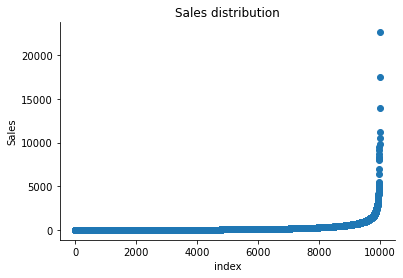

In [8]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

C:\Users\xiaox\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


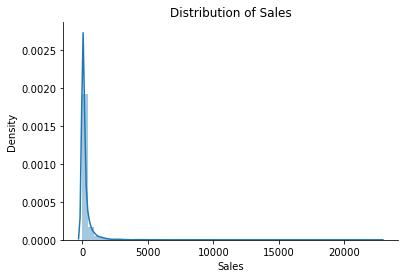

In [9]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [10]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


Profit Distribution

In [11]:
df.Profit.describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

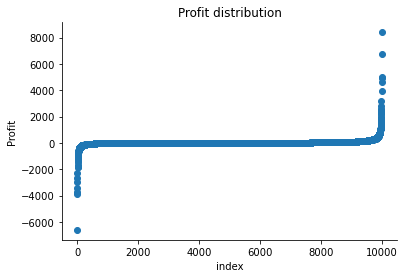

In [12]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

C:\Users\xiaox\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


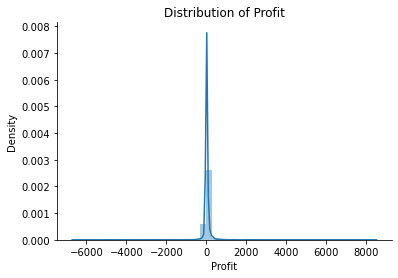

In [13]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

In [14]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


## Isolation Forest - In Scikit-Learn's IsolationForest the decision_function returns values in the range of [-0.5, 0.5] where -.5 is the most anomalous, anything<0 is abnormal

### Anomaly Detection on Sales

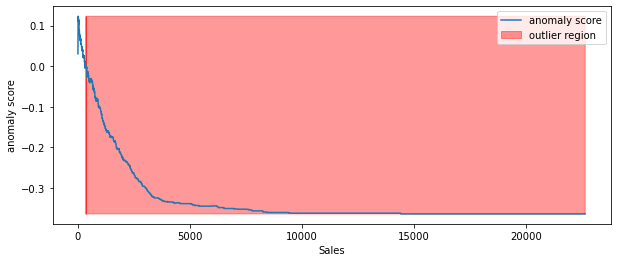

In [4]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)   #1 is normal, -1 is outlier
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

In [36]:
xx=xx.flatten()

arr = np.stack((xx, outlier), axis=1)

df=pd.DataFrame(arr, columns=['value','outlier'])
print(df[df['outlier'] == 1].min())
print(df[df['outlier'] == 1].max())

value      0.444
outlier    1.000
dtype: float64
value      362.9063
outlier      1.0000
dtype: float64


In [49]:
df.loc[df['Sales'] > 1500].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.184,9,0.2,85.3092
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.430,7,0.5,-1665.0522
149,150,CA-2016-114489,2016-12-05,2016-12-09,Standard Class,JE-16165,Justin Ellison,Corporate,United States,Franklin,...,53132,Central,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",1951.840,8,0.0,585.5520
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,78207,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.4,-1359.9920
167,168,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,78207,Central,FUR-CH-10004287,Furniture,Chairs,SAFCO Arco Folding Chair,1740.060,9,0.3,-24.8580


In [17]:
df.iloc[10]

Row ID                                                 11
Order ID                                   CA-2014-115812
Order Date                            2014-06-09 00:00:00
Ship Date                             2014-06-14 00:00:00
Ship Mode                                  Standard Class
Customer ID                                      BH-11710
Customer Name                             Brosina Hoffman
Segment                                          Consumer
Country                                     United States
City                                          Los Angeles
State                                          California
Postal Code                                         90032
Region                                               West
Product ID                                FUR-TA-10001539
Category                                        Furniture
Sub-Category                                       Tables
Product Name     Chromcraft Rectangular Conference Tables
Sales         

The region where the data has low probability to appear is on the right side of the distribution.

### Anomaly detection on Profit

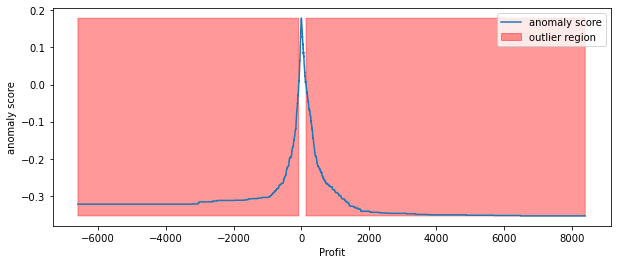

In [18]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

There were two regions that the data has low probability to appear: one on the left side of the distribution, another one on the right side of the distribution.

In [19]:
df.loc[df['Profit'] < -100].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
14,15,US-2015-118983,2015-11-22,2015-11-26,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,76106,Central,OFF-AP-10002311,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,68.8100,5,0.80,-123.8580
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
36,37,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.9200,5,0.60,-147.9630
72,73,US-2015-134026,2015-04-26,2015-05-02,Standard Class,JE-15745,Joel Eaton,Consumer,United States,Memphis,...,38109,South,FUR-CH-10000513,Furniture,Chairs,High-Back Leather Manager's Chair,831.9360,8,0.20,-114.3912


In [20]:
df.iloc[3]

Row ID                                                       4
Order ID                                        US-2015-108966
Order Date                                 2015-10-11 00:00:00
Ship Date                                  2015-10-18 00:00:00
Ship Mode                                       Standard Class
Customer ID                                           SO-20335
Customer Name                                   Sean O'Donnell
Segment                                               Consumer
Country                                          United States
City                                           Fort Lauderdale
State                                                  Florida
Postal Code                                              33311
Region                                                   South
Product ID                                     FUR-TA-10000577
Category                                             Furniture
Sub-Category                                           

In [21]:
df.loc[df['Profit'] > 200].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
24,25,CA-2015-106320,2015-09-25,2015-09-30,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.63,3,0.0,240.2649
54,55,CA-2016-105816,2016-12-11,2016-12-17,Standard Class,JM-15265,Janet Molinari,Corporate,United States,New York City,...,10024,East,TEC-PH-10002447,Technology,Phones,AT&T CL83451 4-Handset Telephone,1029.95,5,0.0,298.6855
144,145,CA-2017-155376,2017-12-22,2017-12-27,Standard Class,SG-20080,Sandra Glassco,Consumer,United States,Independence,...,64055,Central,OFF-AP-10001058,Office Supplies,Appliances,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,839.43,3,0.0,218.2518
149,150,CA-2016-114489,2016-12-05,2016-12-09,Standard Class,JE-16165,Justin Ellison,Corporate,United States,Franklin,...,53132,Central,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",1951.84,8,0.0,585.5520


In [22]:
df.iloc[1]

Row ID                                                           2
Order ID                                            CA-2016-152156
Order Date                                     2016-11-08 00:00:00
Ship Date                                      2016-11-11 00:00:00
Ship Mode                                             Second Class
Customer ID                                               CG-12520
Customer Name                                          Claire Gute
Segment                                                   Consumer
Country                                              United States
City                                                     Henderson
State                                                     Kentucky
Postal Code                                                  42420
Region                                                       South
Product ID                                         FUR-CH-10000454
Category                                                 Furni

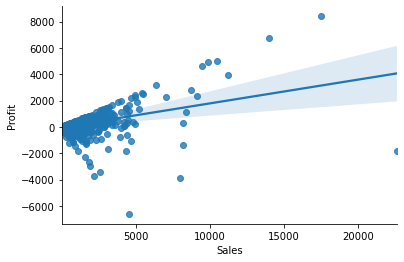

In [24]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

In [25]:
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [26]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [27]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

Cluster-based Local Outlier Factor (CBLOF)

OUTLIERS: 100 INLIERS: 9894


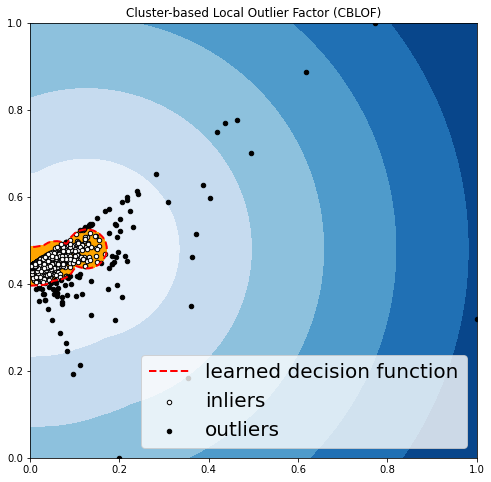

In [28]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

OUTLIERS: 90 INLIERS: 9904


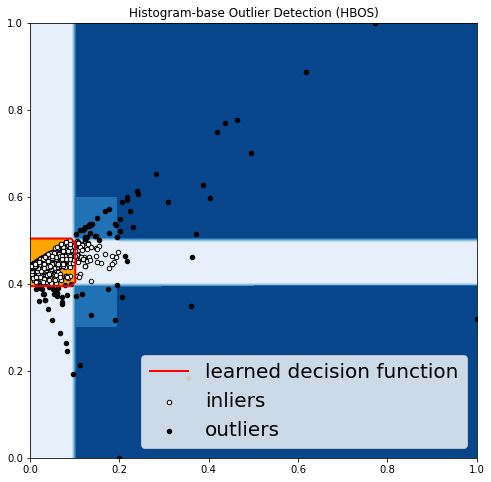

In [29]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

OUTLIERS:  100 INLIERS:  9894


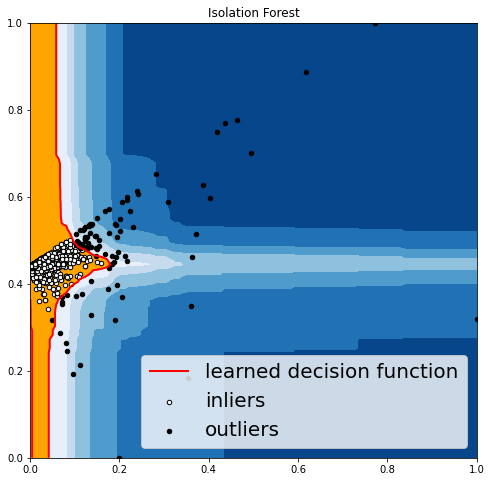

In [30]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

OUTLIERS:  91 INLIERS:  9903


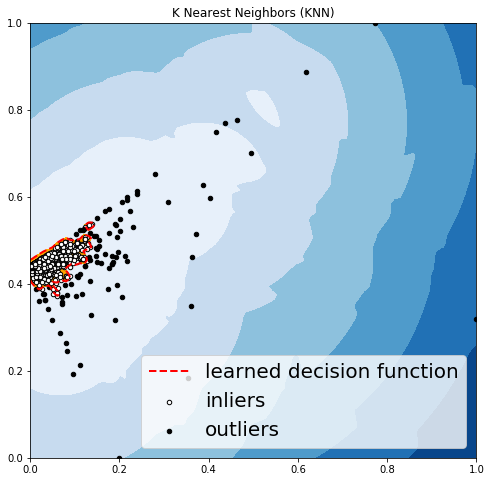

In [0]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K Nearest Neighbors (KNN)')
plt.show();

In [0]:
df1.loc[df1['outlier'] == 1].tail(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,outlier
9231,9232,CA-2014-148383,2014-12-27,2014-12-31,Standard Class,RP-19390,Resi Pölking,Consumer,United States,Phoenix,Arizona,85023,West,OFF-BI-10003650,Office Supplies,Binders,GBC DocuBind 300 Electric Binding Machine,0.041802,6,0.70,0.393714,1
9270,9271,US-2017-102183,2017-08-21,2017-08-28,Standard Class,PK-19075,Pete Kriz,Consumer,United States,New York City,New York,10035,East,OFF-BI-10001359,Office Supplies,Binders,GBC DocuBind TL300 Electric Binding System,0.190171,6,0.20,0.536875,1
9412,9413,CA-2015-164777,2015-01-27,2015-01-29,First Class,SC-20305,Sean Christensen,Consumer,United States,Los Angeles,California,90036,West,FUR-CH-10002024,Furniture,Chairs,HON 5400 Series Task Chairs for Big and Tall,0.123839,5,0.20,0.440000,1
9425,9426,CA-2014-116246,2014-09-12,2014-09-17,Second Class,LW-17215,Luke Weiss,Consumer,United States,New York City,New York,10035,East,FUR-CH-10002024,Furniture,Chairs,HON 5400 Series Task Chairs for Big and Tall,0.167190,6,0.10,0.468039,1
9639,9640,CA-2015-116638,2015-01-28,2015-01-31,Second Class,JH-15985,Joseph Holt,Consumer,United States,Concord,North Carolina,28027,South,FUR-TA-10000198,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,0.189822,13,0.40,0.315845,1
9649,9650,CA-2016-107104,2016-11-26,2016-11-30,Standard Class,MS-17365,Maribeth Schnelling,Consumer,United States,Los Angeles,California,90045,West,FUR-BO-10002213,Furniture,Bookcases,DMI Eclipse Executive Suite Bookcases,0.150464,8,0.15,0.450687,1
9660,9661,CA-2016-160717,2016-06-06,2016-06-11,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Santa Barbara,California,93101,West,TEC-PH-10001459,Technology,Phones,Samsung Galaxy Mega 6.3,0.133558,9,0.20,0.455120,1
9741,9742,CA-2015-117086,2015-11-08,2015-11-12,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,5408,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",0.194560,5,0.00,0.507542,1
9774,9775,CA-2014-169019,2014-07-26,2014-07-30,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,78207,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,0.096172,8,0.80,0.193206,1
9857,9858,CA-2015-164301,2015-03-26,2015-03-30,Standard Class,EB-13840,Ellis Ballard,Corporate,United States,Seattle,Washington,98103,West,FUR-TA-10001889,Furniture,Tables,Bush Advantage Collection Racetrack Conference...,0.149891,8,0.00,0.480724,1


In [0]:

df = pd.read_excel("Superstore.xls")

In [0]:
df.iloc[1995]

Row ID                                                        1996
Order ID                                            US-2017-147221
Order Date                                     2017-12-02 00:00:00
Ship Date                                      2017-12-04 00:00:00
Ship Mode                                             Second Class
Customer ID                                               JS-16030
Customer Name                                            Joy Smith
Segment                                                   Consumer
Country                                              United States
City                                                       Houston
State                                                        Texas
Postal Code                                                  77036
Region                                                     Central
Product ID                                         OFF-AP-10002534
Category                                           Office Supp

In [0]:
df.iloc[9649]

Row ID                                            9650
Order ID                                CA-2016-107104
Order Date                         2016-11-26 00:00:00
Ship Date                          2016-11-30 00:00:00
Ship Mode                               Standard Class
Customer ID                                   MS-17365
Customer Name                      Maribeth Schnelling
Segment                                       Consumer
Country                                  United States
City                                       Los Angeles
State                                       California
Postal Code                                      90045
Region                                            West
Product ID                             FUR-BO-10002213
Category                                     Furniture
Sub-Category                                 Bookcases
Product Name     DMI Eclipse Executive Suite Bookcases
Sales                                          3406.66
Quantity  

In [0]:
df.iloc[9270]

Row ID                                                 9271
Order ID                                     US-2017-102183
Order Date                              2017-08-21 00:00:00
Ship Date                               2017-08-28 00:00:00
Ship Mode                                    Standard Class
Customer ID                                        PK-19075
Customer Name                                     Pete Kriz
Segment                                            Consumer
Country                                       United States
City                                          New York City
State                                              New York
Postal Code                                           10035
Region                                                 East
Product ID                                  OFF-BI-10001359
Category                                    Office Supplies
Sub-Category                                        Binders
Product Name     GBC DocuBind TL300 Elec